# <center>ViTSTR-Transducer training

In [1]:
import os
os.environ['NUMEXPR_MAX_THREADS'] = '20'
# Project imports
from src.net.model import ViTSTRTransducer
from src.data_processing.dataset import Collate, Database, LmdbDataset
from src.data_processing.vocabulary import Vocabulary
from src.utils.predictor import Predictor
from src.utils.history import History
# Third party imports
import torch
import lightning as L
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.utilities import CombinedLoader
from lightning.pytorch.loggers import CSVLogger
from multiprocessing import cpu_count
torch.set_float32_matmul_precision('high')

# Project constants
NUM_WORKERS = cpu_count()
MAX_EPOCHS = 3
BATCH_SIZE = 64
DATABASE_TRAIN_1_PATH = '/mnt/s/CV/data_lmdb_release/training/MJ/MJ_train'
DATABASE_TRAIN_2_PATH = '/mnt/s/CV/data_lmdb_release/training/ST'
DATABASE_VALID_PATH = '/mnt/s/CV/data_lmdb_release/validation'
DATABASE_TEST_PATH = '/mnt/s/CV/data_lmdb_release/evaluation/IC13_857'

# Model hyperparametres
D_MODEL = 256
NUM_HEADS = 4
INPUT_CHANNELS = 1
LR_MAX = 1e-4
LR_MIN = 1e-5
T_MAX = 2

## Initialize vocabulary, datasets and dataloaders

In [2]:
vocab = Vocabulary()
# Initialize databases with images and labels
train_db_1 = Database(DATABASE_TRAIN_1_PATH, max_readers=NUM_WORKERS) # MJ_train
train_db_2 = Database(DATABASE_TRAIN_2_PATH, max_readers=NUM_WORKERS) # ST
valid_db = Database(DATABASE_VALID_PATH, max_readers=NUM_WORKERS)
test_db = Database(DATABASE_TEST_PATH, max_readers=NUM_WORKERS) # IC13_857
# Initialize datasets
dataset_train_1 = LmdbDataset(train_db_1, vocab, sample='train')
dataset_train_2 = LmdbDataset(train_db_2, vocab, sample='train')
dataset_valid = LmdbDataset(valid_db, vocab, sample='valid')
dataset_test = LmdbDataset(test_db, vocab, sample='test')
# Collate callable class
collate = Collate(pad_idx=vocab.char2idx['<PAD>'])
# Initialize dataloaders
dataloader_train_1 = DataLoader(dataset_train_1, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, num_workers=NUM_WORKERS)
dataloader_train_2 = DataLoader(dataset_train_2, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=True, num_workers=NUM_WORKERS)
dataloader_train = CombinedLoader([dataloader_train_1, dataloader_train_2])
dataloader_valid = DataLoader(dataset_valid, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=False, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test, batch_size=BATCH_SIZE, collate_fn=collate, shuffle=False, num_workers=NUM_WORKERS)
# Print dataset sizes
print(f'Vocabulary size: {len(vocab)}')
print(f'Train size: {min(len(dataset_train_1), len(dataset_train_2))}')
print(f'Val/test size: {len(dataset_valid)}/{len(dataset_test)}')

Vocabulary size: 72
Train size: 5522808
Val/test size: 6992/857


## Configure model and callbacks

In [3]:
# Model
config = dict(
    vocab=vocab,
    d_model=D_MODEL,
    input_channels=INPUT_CHANNELS,
    lr_max=LR_MAX,
    lr_min=LR_MIN,
    t_max=T_MAX,
    num_heads=NUM_HEADS
)
model = ViTSTRTransducer(**config).cuda()
# Callbacks and logger
logger = CSVLogger('logs')
lr_monitor_callback = LearningRateMonitor(logging_interval='step')
checkpoint_callback = ModelCheckpoint(
    dirpath='weights',
    filename='checkpoint',
    save_weights_only=True,
    mode='min',
    monitor='val_CE'
)

## Training

In [4]:
trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    enable_checkpointing=True,
    callbacks=[
        checkpoint_callback,
        lr_monitor_callback,
    ], 
    logger=logger, 
    log_every_n_steps=len(dataloader_train_2) # Every epoch
)
trainer.fit(model=model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_valid)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Evaluation on test set

In [5]:
trainer.test(model, dataloaders=dataloader_test, ckpt_path='weights/checkpoint-v2.ckpt');

Restoring states from the checkpoint path at weights/checkpoint-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at weights/checkpoint-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_CE          │    0.07453146576881409    │
└───────────────────────────┴───────────────────────────┘

## Load best checkpoint and draw history

In [6]:
model = model.__class__.load_from_checkpoint('weights/checkpoint-v2.ckpt', vocab=vocab)

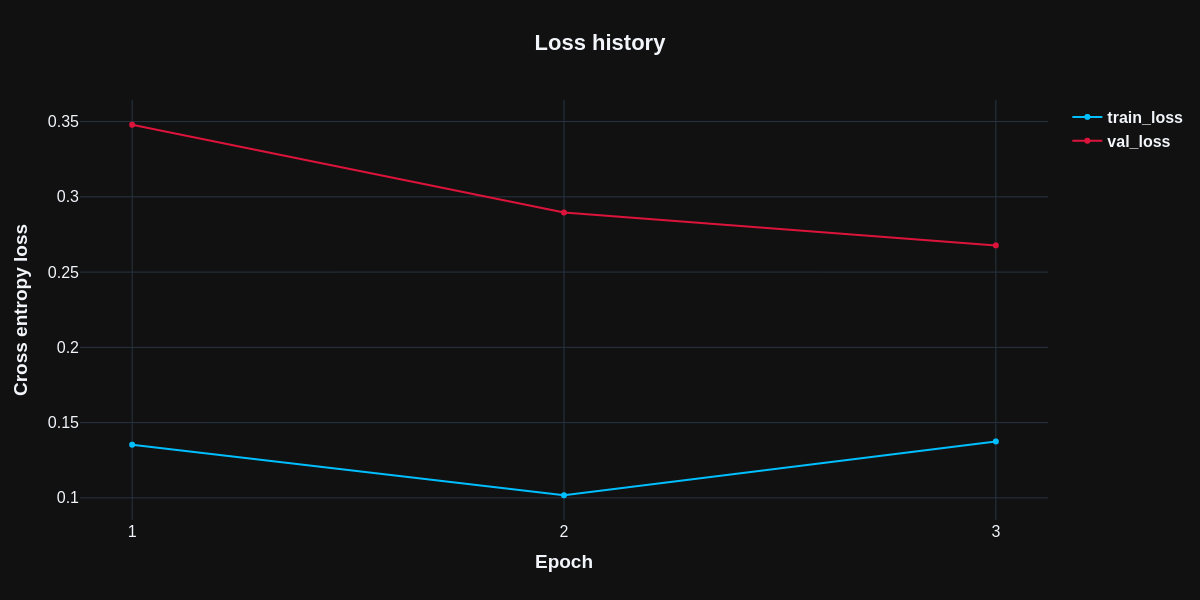

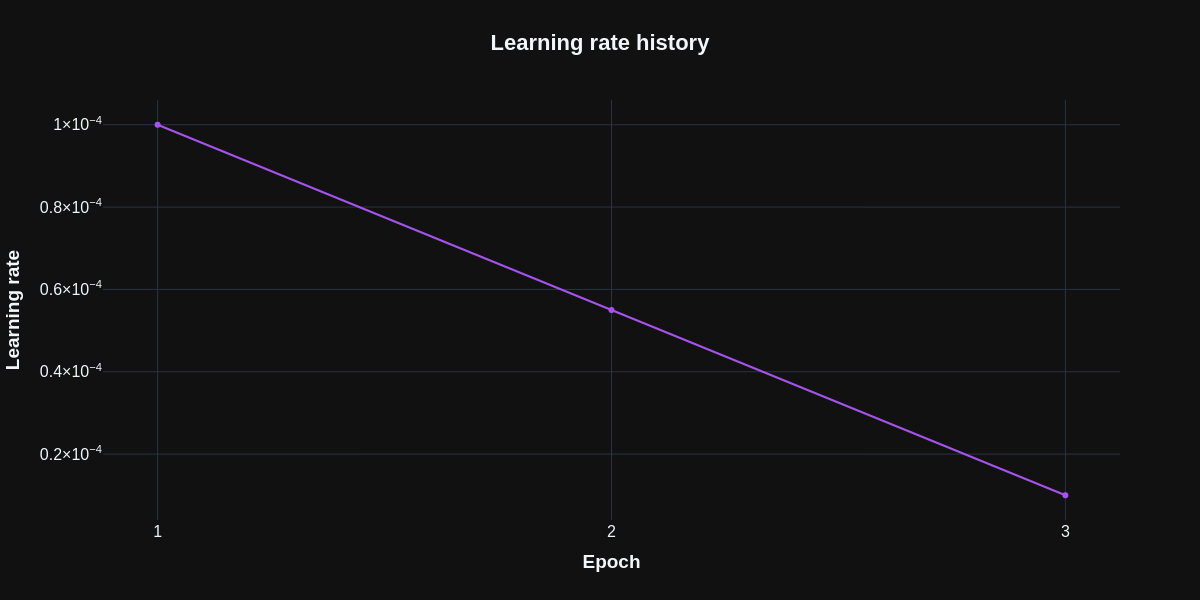

In [7]:
history_visualizer = History('logs/lightning_logs/version_2/metrics.csv')
history_visualizer.draw_history()

## Visualize predictions from test set

Predicted caption: tiredness
Target caption: tiredness


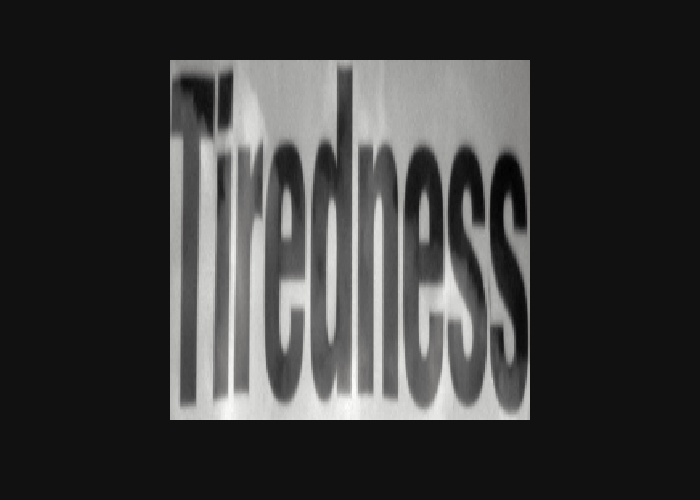

Predicted caption: education
Target caption: education


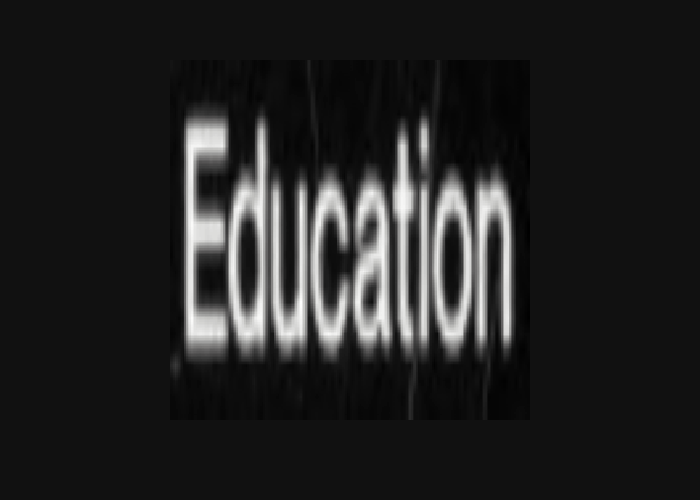

Predicted caption: floor
Target caption: floor


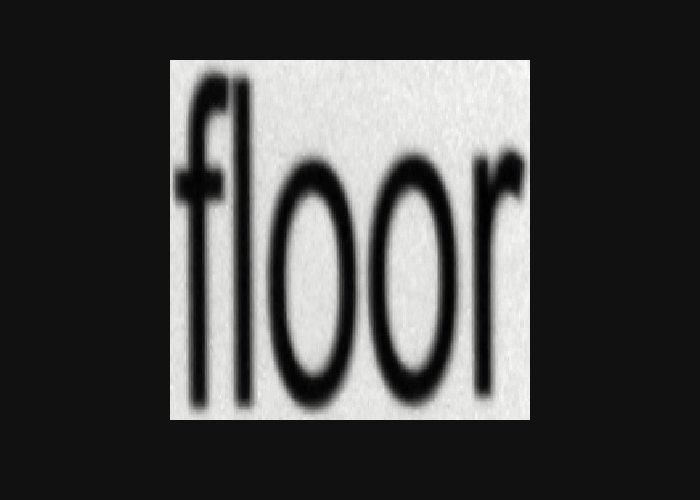

Predicted caption: standated
Target caption: sixth


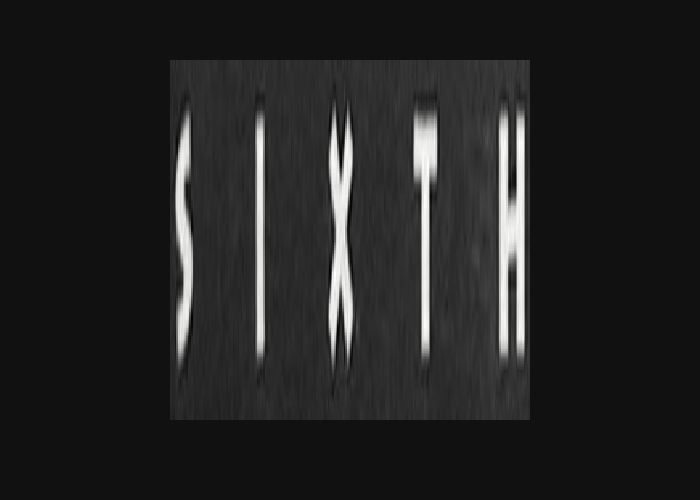

Predicted caption: department
Target caption: department


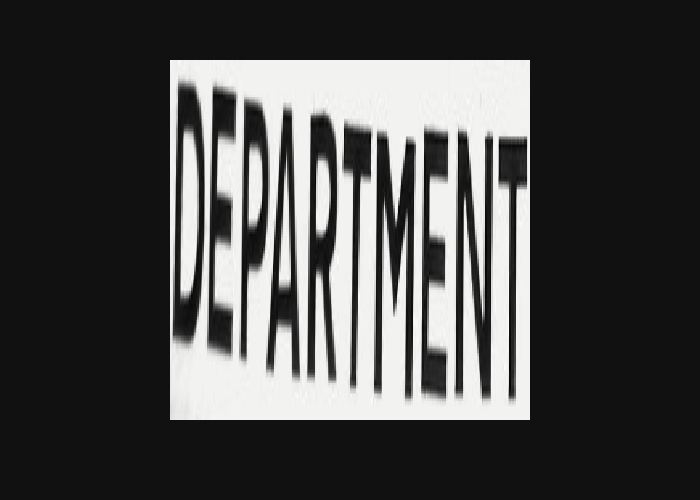

Predicted caption: colchester
Target caption: colchester


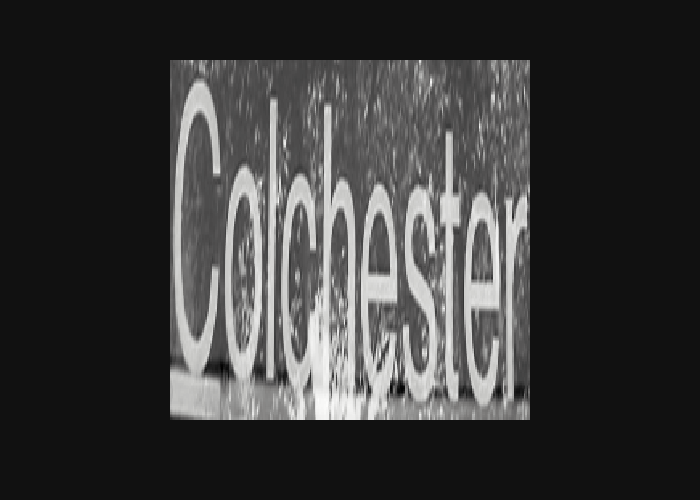

Predicted caption: this
Target caption: this


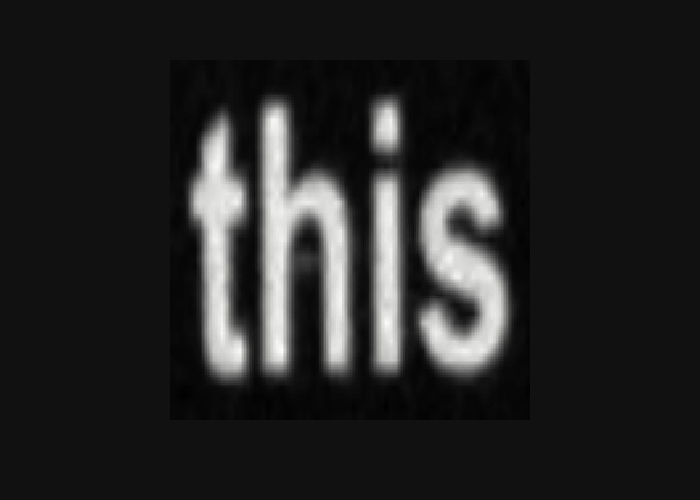

Predicted caption: natural
Target caption: natural


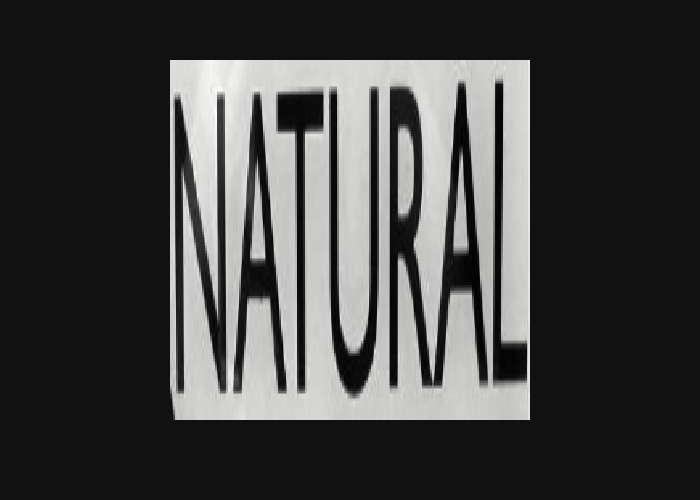

Predicted caption: trail
Target caption: trail


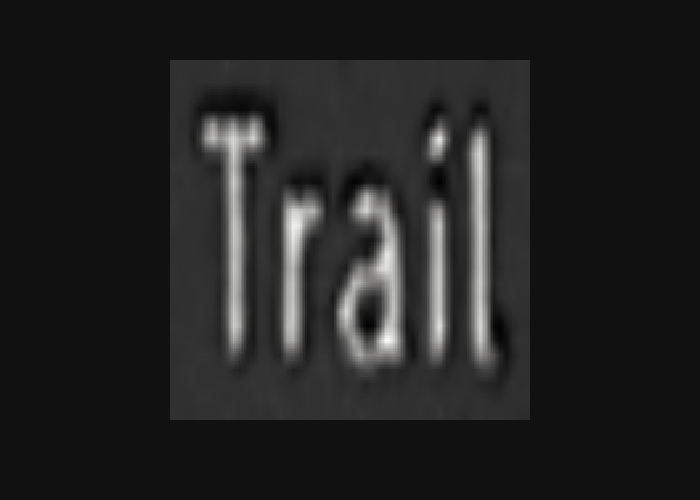

Predicted caption: udx
Target caption: udx


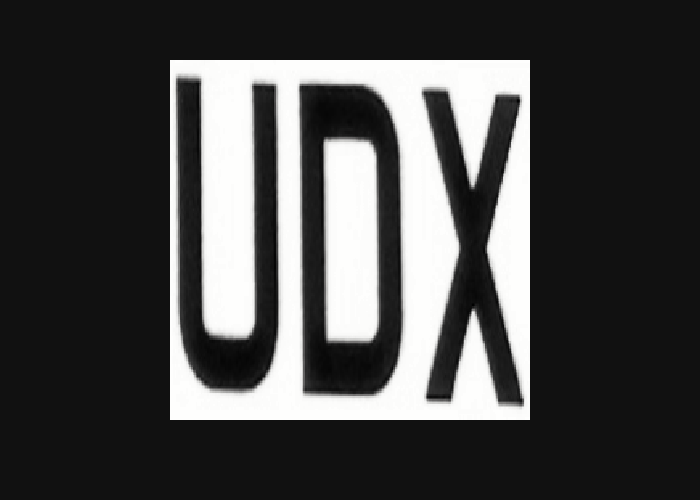

In [8]:
predictions_visuazlier = Predictor()
predictions_visuazlier.caption_dataloader(dataloader=dataloader_test, model=model, n_samples=10)